# AEDAT files annotation

This tutorial will cover all the basic steps needed to provide annotations to AEDAT files. The overall pipeline can be divided in three sections:

1. Creating a video from the aedat file.
2. Use CVAT to define and perform an annotation task on the video file.
3. Create the annotated dataset.

## 1. Creating video for annotation

The function `aedat_convert_to_video(file_path: str, **kwargs)` can be used to create an `mp4` video from an aedat file. It's necessary to pass the wanted `time_window` as a `kwargs` as follows:

```
>>> aedat_convert_to_video(aedat_file, time_window=10000)
```

Behind the scenes this function:

1. Loads the `aedat` file with the already existing function `aermanager.dataset_generator.dataset_content_generator`. The `**kwargs` will be forwarded to the `dataset_content_generator(...)` function.
2. Normalizes the frames between 0 and 255
3. Saves the frames in a video, the video has the same filename of the aedat file with `mp4` extension.

In [1]:
from aermanager.cvat.aedat_to_video import aedat_convert_to_video

aedat_file = '/home/marco/repos/demos/cvat-demo/aedat/four_obj_static.aedat4'

In [8]:
%%time
aedat_convert_to_video(aedat_file, time_window=10000)

CPU times: user 3.7 s, sys: 292 ms, total: 3.99 s
Wall time: 4.82 s


In [ ]:
!ls /home/marco/repos/demos/cvat-demo/aedat/*mp4

/home/marco/repos/demos/cvat-demo/aedat/four_obj_static.mp4


In [ ]:
video_file_name = '/home/marco/repos/demos/cvat-demo/aedat/four_obj_static.mp4'

In [ ]:
!vlc $video_file_name &> /dev/null

## 2. Creating an annotation task on CVAT

This step should be carried out with the CVAT WUI, even though tools are provided to accomplish this programmaticaly (see `cli.py` in the official repo: https://github.com/openvinotoolkit/cvat/tree/develop/utils/cli). **Currently only one video file per annotation task is supported.**

From a given task, the annotations should be downloaded:

    - With the format "CVAT for a video 1.1" (XML) if the annotation is used to label and track ROIs (both bounding boxes and polygons)
    - With the format "CVAT for a images 1.1" (XML) if the annotation is used to tag frames.
    - With both formats separately if both types of annotations are used.


This is due to the fact that the "for video" annotations only exports informations about ROIs and the "for images" annotations exports only informations about frame tags (to be fair "for images" exports also informations about ROIs, but drops the ROIs identifier information).

## 3. Generate the annotated dataset.

A dataset of annotated event frames can be build by using the function function `aermanager.annotate_aedat.cvat_dataset_generator.gen_annotated_dataset_from_list`. This function requires as arguments:

1. `events_list`: a `list` with all the `aedat` files to annotate.
    - i.e: `event_files = ['/home/marco/awesome_aedat.aedat4']`
2. `labels` a list of dictionaries containing the paths for ROIs annotations and tags:
    - i.e: `[{'rois_file': '/home/marco/awesome_rois_ann.xml', 'tags_file':'/home/marco/awesome_tags_ann.xml'}]`
    - It's not necessary for both annotations to exist:
        - i.e: `[{'rois_file': '/home/marco/awesome_rois_ann.xml'}]`
        - i.e: `[{'tags_file':'/home/marco/awesome_tags_ann.xml'}]`

The `**kwargs` of `gen_annotated_dataset_from_list` will be forwarded to the `dataset_content_generator(...)` function: it's not necessary for the `time_window` to be the same used for the annotation video generation.

In [11]:
from aermanager.cvat_dataset_generator import gen_annotated_dataset_from_list

In [12]:
aedat_file = '/home/marco/repos/demos/cvat-demo/aedat/four_obj_static.aedat4'
rois_file = '/home/marco/repos/aermanager/test/dummy_video_annotations.xml'
tags_file = '/home/marco/repos/aermanager/test/dummy_image_annotations.xml'

In [13]:
event_files = [aedat_file]
labels = [{'rois_file': rois_file, 'tags_file':tags_file}]

In [14]:
%%time
gen_annotated_dataset_from_list(event_files, labels, destination_path="/home/marco/dataset_example/", spike_count=5000)

0it [00:00, ?it/s]<timed eval>:1: UserWarning: Folder /home/marco/dataset_example/four_obj_static_76b0a already exists
1it [00:26, 26.68s/it]

CPU times: user 24 s, sys: 2.66 s, total: 26.6 s
Wall time: 26.7 s


This step is really processor heavy and is not parallelized by pandas. In order to scale it we can use the following tools:

- `py-polars` (similar to `pandas`, a faster implementation written in Rust), good on the same data size range (between 0-15GB in RAM), has a good support for multithreaded computation.
- `dask`: native multiprocess support, supports GPU computation, good up to ~100GB.
- `py-spark`: solution to be discussed with an MLOps expert. Not an easy setup, but should be considered on the longer term. Good for datasets >100GB.
- Writing to hdf5 seems to be a bottleneck (the greater the number of files, the greater the number sequential writes to disk)

## 4. Load the annotated HDF files

The following cells shows how it's possible to:

- List all HDF files in a dataset folder
- Load the labels existing in a frame
- Load the labels LUT ('name in cvat as string' -> integer id used in the numpy array)
- Load the ROI ID -> Label ID dictionary
- Load the annotated events as a structured array

In [13]:
dataset_folder = '/home/marco/dataset_example/four_obj_static_76b0a'

In [14]:
!ls $dataset_folder/ 2> /dev/null | head

0.h5
1000.h5
1001.h5
1002.h5
1003.h5
1004.h5
1005.h5
1006.h5
1007.h5
1008.h5


In [15]:
def list_dataset_files(source_path: str, extension: str = 'h5'):
    
    import re
    
    from os import listdir
    
    files = [f for f in listdir(source_path) if f.endswith('.' + extension)]

    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    return [f'{source_path}/{file}' for file in files]

In [16]:
from aermanager.cvat_dataset_generator import load_labels_lut, load_rois_lut, load_annotated_slice, load_frame_shape

In [17]:
files = list_dataset_files(dataset_folder)
print(f'First dataset file: {files[0]}')

First dataset file: /home/marco/dataset_example/four_obj_static_76b0a/0.h5


In [18]:
file = files[100] # pick an example file

In [19]:
labels_lut = load_labels_lut(file)
print(f'Labels LUT: {labels_lut}')

Labels LUT: {b'__Empty_Default__': 0, b'Pen': 1, b'Rabbit': 2, b'Box': 3, b'Mug': 4, b'Whole_frame_tag_1': 5, b'whole_frame_tag_2': 6}


In [20]:
rois_lut = load_rois_lut(file)
print(f'Rois LUT: {rois_lut}')

Rois LUT: {0: b'Mug', 1: b'Rabbit', 2: b'Box', 3: b'Pen'}


In [21]:
slice_events, slice_labels = load_annotated_slice(file)
print(f'Slice labels: {slice_labels}')
print(f'Events type: {slice_events.dtype}')

print(slice_events)

Slice labels: [b'Pen', b'Rabbit', b'Box', b'Mug', b'Whole_frame_tag_1', b'whole_frame_tag_2']
Events type: [('x', '<u2'), ('y', '<u2'), ('t', '<u8'), ('p', '?'), ('id', '<f8')]
[( 30, 160, 1579513476815399,  True, nan)
 ( 26, 136, 1579513476815399, False, nan)
 ( 26, 136, 1579513476815399, False, nan) ...
 (258, 171, 1579513476821446, False,  2.)
 (203, 205, 1579513476821446,  True, nan)
 (203, 205, 1579513476821446,  True, nan)]


In [22]:
shape = load_frame_shape(file)
print(shape)

(2, 260, 346)


<IPython.core.display.Javascript object>


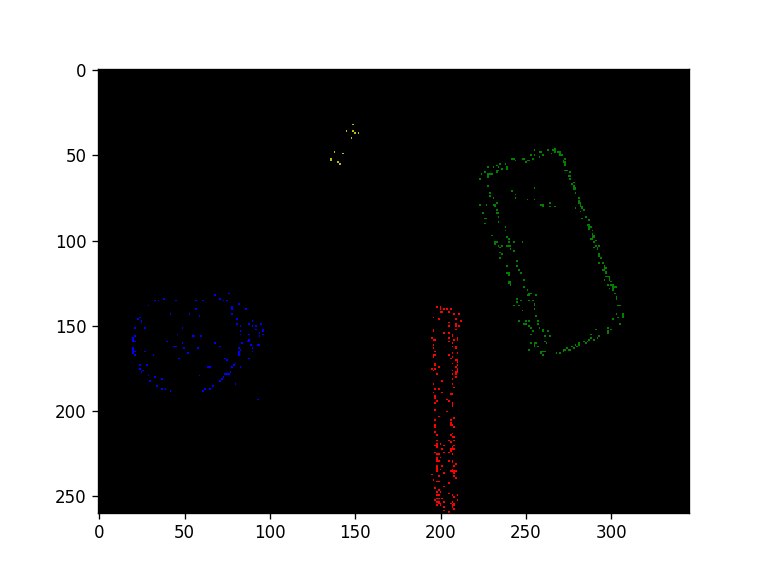

interactive(children=(IntSlider(value=75, description='x', max=150), Output()), _dom_classes=('widget-interact…

In [23]:
%matplotlib notebook
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

x_max = shape[2]
y_max = shape[1]

image = np.zeros((y_max, x_max), dtype='uint8')

fig = plt.figure()
p = fig.add_subplot(1, 1, 1)

cmap = colors.ListedColormap(['k','b','y','g','r'])

im_plot = p.imshow(image, interpolation='nearest', vmin=0, vmax=4, cmap=cmap)

def update(x):
    image = np.zeros((y_max, x_max), dtype='uint8')
    events, labels = load_annotated_slice(files[x])
    print(f'This frame has the following labels: {labels}')
    image.fill(0)
    image[events['y'], events['x']] = events['id'] + 1
    im_plot.set_data(image)
    
    fig.canvas.draw()
    
widgets.interact(update, x=(0, 150)); # The range of frames was empirically set.